# TODO: Bring in the necessary components from cph to remove the dependency.
## This notebook will not run for external users currently

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
!date

# Simple Disease Model

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

import ceam_public_health.components as cphc
import vivarium

n_simulants = 10*1000
n_days = 365*10
t_start = pd.Timestamp('1990-01-01')



In [3]:
import ceam_experiments.hello_world.components.hello_world as cehwch
import vivarium.test_util as vtu

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
import importlib

In [7]:
importlib.reload(cehwch)

<module 'ceam_experiments.hello_world.components.hello_world' from '/snfs2/HOME/abie/projects/2017/ceam_development/ceam-experiments/ceam_experiments/hello_world/components/hello_world.py'>

In [8]:
components = [vtu.TestPopulation(),  # Note from James: This is now a class
              vtu.age_simulants,
              cehwch.SimpleMortality(),
              cehwch.SimpleIntervention(),
              cehwch.SimpleMetrics()
]

In [9]:
simulation = vtu.setup_simulation(components, population_size=n_simulants, start=t_start)
metrics = simulation.values.get_value('metrics')

In [10]:
simulation.population.population.head()

,age,alive,sex,exit_time,location,entrance_time
0,3.565546,alive,Male,NaT,180,1990-01-01
1,0.702799,alive,Male,NaT,180,1990-01-01
2,1.485133,alive,Female,NaT,180,1990-01-01
3,3.640910,alive,Male,NaT,180,1990-01-01
4,3.489277,alive,Female,NaT,180,1990-01-01


In [11]:
simulation.population.population.dtypes

age                     float64
alive                  category
sex                      object
exit_time        datetime64[ns]
location                  int64
entrance_time    datetime64[ns]
dtype: object

In [12]:
simulation.population.population.alive.cat.categories

Index(['alive', 'dead', 'untracked'], dtype='object')

In [13]:
pd.Series()

Series([], dtype: float64)

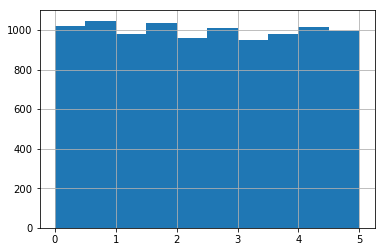

In [14]:
simulation.population.population.age.hist()

In [ ]:
vtu.pump_simulation(simulation, duration=pd.Timedelta(days=n_days))

In [ ]:
simulation.population.population.age.hist()

In [ ]:
simulation.population.population.exit_time.describe()

In [ ]:
df = simulation.population.population
df.alive.value_counts()

In [ ]:
cdr = (df.alive != 'alive').sum() / (n_days/365*len(df))
print('CDR = {:.1f} / 1000'.format(1000*cdr))